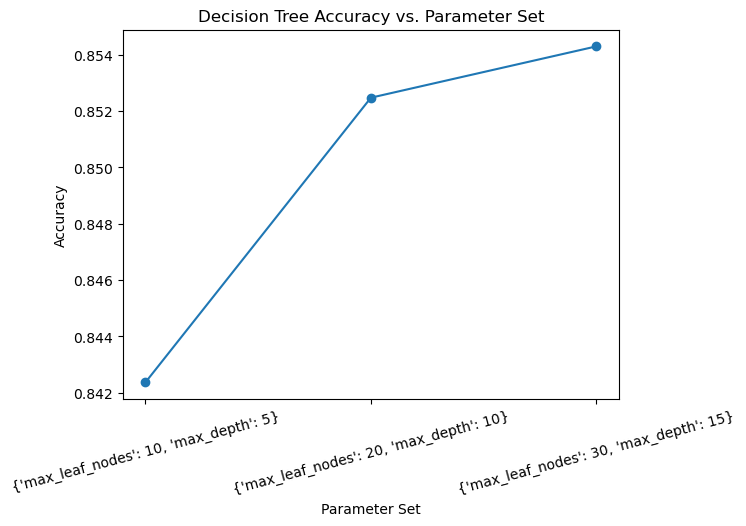

In [5]:
import pandas as pd
import rpy2.robjects as ro
import numpy as np
from sklearn.preprocessing import LabelEncoder
from rpy2.robjects import pandas2ri # R 和 Python 之间的数据转换

column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
def loadAdultData(URL):
    url = URL
    dataset = pd.read_csv(url, names=column_names, sep=",\s*", engine="python")
    dataset = dataset.replace("?", np.nan)
    dataset.dropna(inplace=True)
    # Force the data type of all columns to be strings
    for col in dataset.columns:
        dataset[col] = dataset[col].astype(str)
    return dataset


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

data = pd.read_csv(url, names=column_names, sep=",\s*", engine="python")

data = data.replace("?", np.nan)
data.dropna(inplace=True)
data = pd.get_dummies(data, columns=["workclass", "education", "marital_status", "occupation", "relationship", "race", "native_country"])
data['sex'] = data['sex'].replace({'Male': 0, 'Female': 1})


X = data.drop("income", axis=1)
y = data["income"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

cart = DecisionTreeClassifier(criterion='gini')
cart.fit(X_train, y_train)
y_cart = cart.predict(X_test)
cart_report = classification_report(y_test, y_cart,output_dict=True)


id3 = DecisionTreeClassifier(criterion='entropy')
id3.fit(X_train, y_train)
y_id3 = id3.predict(X_test)
id3_report = classification_report(y_test, y_id3,output_dict=True)

cart_df = pd.DataFrame(cart_report).transpose()
id3_df = pd.DataFrame(id3_report).transpose()

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

params = [
    {"max_leaf_nodes": 10, "max_depth": 5},
    {"max_leaf_nodes": 20, "max_depth": 10},
    {"max_leaf_nodes": 30, "max_depth": 15}
]

models = []
accuracies = []
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
import pydotplus
pydotplus.graphviz_executable = "C:\\Program Files\\Graphviz\\bin\\dot.exe"
for param_set in params:
    model = DecisionTreeClassifier(max_leaf_nodes=param_set["max_leaf_nodes"], max_depth=param_set["max_depth"])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    models.append(model)
    accuracies.append(accuracy)
    dot_data = export_graphviz(model, out_file=None,
                               feature_names=X_train.columns,
                               class_names=['<=50k','>50k'],
                               filled=True, rounded=True,
                               special_characters=False)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_png(f"decision_tree_{param_set['max_leaf_nodes']}_{param_set['max_depth']}.png")
    Image(graph.create_png())


plt.plot([str(param_set) for param_set in params], accuracies, marker='o')
plt.xlabel("Parameter Set")
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy vs. Parameter Set")
plt.xticks(rotation=15)
plt.show()

#C4.5-----------------------------------------------------------------------------------------------------

#Train Data
data_train = loadAdultData("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data")

#Test Data
data_test = loadAdultData("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test")
data_test = data_test.drop(1)

#LabelEncoder
merged_data = pd.concat([data_train, data_test], ignore_index=True)  #
label_encoder = LabelEncoder()  # 创建LabelEncoder对象  字串數據改為數字編碼
for column in merged_data.columns[:-1]:
    merged_data[column] = label_encoder.fit_transform(merged_data[column])
merged_data['income'] = merged_data['income'].astype('category')      #将income转换为分类变量
#分割data
data_train = merged_data.iloc[:len(data_train)]

data_test = merged_data.iloc[len(data_test):]


# Convert Python data frames to R data frames
pandas2ri.activate() #激活 Pandas 和 R 数据框之间的转换功能
ro.globalenv['data_train'] = data_train
ro.globalenv['data_test'] = data_test

# Define the R code for C4.5 model training
c4_5_code = """
#load the required R package 'RWeka'
library(RWeka)

formula <- income ~ age + workclass + fnlwgt + education + education_num + marital_status + occupation + relationship + race + sex + capital_gain + capital_loss + hours_per_week + native_country
data_train$income <- factor(data_train$income, levels=levels(data_train$income))

my_model <- J48(formula, data=data_train, control = Weka_control(M=2), options = NULL)
"""
# Execute the C4.5 model training in R
ro.r(c4_5_code)

# Prepare the 'income' column for R
ro.r("data_test$income <- as.factor(data_test$income)")
# Predict using the trained model
ro.r("predicted <- predict(my_model, newdata=data_test)")
# Calculate accuracy
ro.r("accuracy <- sum(predicted == data_test$income) / length(predicted)")

ro.r("predicted <- as.character(predicted)")
predicted = ro.r("predicted")
accuracy = ro.r("accuracy")[0]

results = pd.DataFrame({'Predicted': predicted, 'Actual': data_test['income']})

#excel-------------------------------------------------------------------------

excel_writer = pd.ExcelWriter('C4.5_Results.xlsx', engine='xlsxwriter')
results.to_excel(excel_writer, sheet_name='C4.5_Results', index=False)
cart_df.to_excel(excel_writer, sheet_name="cart_report")
id3_df.to_excel(excel_writer, sheet_name="id3_report")

workbook = excel_writer.book
worksheet = excel_writer.sheets['C4.5_Results']
worksheet.write('D1', 'Accuracy')
worksheet.write('E1', accuracy)
excel_writer.close()
# Clean up the R environment if needed  釋放內存
ro.r("rm(my_model)")